The aim of our project is to replicate and expand upon the research presented in the paper titled "Large scale pest classification using efficient Convolutional Neural Network with augmentation and regularizers" published on ScienceDirect. We specifically focus on the MobileNetV2 model due to its efficiency and suitability for deployment on mobile devices. Our contribution includes not only reproducing the results of the original study but also testing additional baseline models like VGG16 and ResNet to compare performance. This approach aims to validate the robustness of MobileNetV2 and explore the effectiveness of alternative architectures. 

Automated insect pest classification systems using deep learning techniques, especially Convolutional Neural Networks (CNNs) and advanced image processing algorithms, provide an effective solution. These systems can distinguish and categorize insect pests based on their visual characteristics, enabling researchers, farmers, and pest control professionals to quickly identify pests, understand their behavior, and implement targeted control measures.
Dataset URL: https://github.com/xpwu95/IP102/tree/master

1.	Data Augmentation: 
•	CutMix: Generates new training samples by cutting and mixing parts of images, increasing data diversity and generalization ability. we use this in three basline models VGG16, Resnet50 and MobileNet2.
 
2.	Sparse Regularization: 
•	Applied sparse regularization to prevent overfitting and stabilize the training process. This method minimizes the weight of feature maps, promoting sparsity and reducing overfitting risk.
Training Configuration 
The training configuration for all models is as follows: 
•	Optimizer: The AdamW optimizer with an initial learning rate of 0.0001 was chosen for its effectiveness in handling noisy gradients and built-in L2 regularization (weight decay). 



In [ ]:
#after this line mobilenet2 model using sparse loss and cutmix dynamic learning rate adamW dynamic learning rate

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
import os
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom dataset class defnition 
class CustomDataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_labels = []
        
        with open(txt_file, 'r') as file:
            for line in file.readlines():
                parts = line.strip().split(' ')
                self.image_labels.append((parts[0], int(parts[1])))
                
    def __len__(self):
        return len(self.image_labels)
    
    def __getitem__(self, idx):
        img_name, label = self.image_labels[idx]
        img_path = os.path.join(self.root_dir, img_name)
        try:
            image = Image.open(img_path).convert('L')  
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

def main():

    writer = SummaryWriter('runs/experiment_name')
    

    train_dataset = CustomDataset(txt_file='/Users/kim/Downloads/hw2/ip102_v1.1/train.txt', root_dir='/Users/kim/Downloads/ip102_v1.1/images', transform=transform)
    val_dataset = CustomDataset(txt_file='/Users/kim/Downloads/hw2/ip102_v1.1/val.txt', root_dir='/Users/kim/Downloads/ip102_v1.1/images', transform=transform)
    test_dataset = CustomDataset(txt_file='/Users/kim/Downloads/hw2/ip102_v1.1/test.txt', root_dir='/Users/kim/Downloads/ip102_v1.1/images', transform=transform)


    small_train_dataset = Subset(train_dataset, range(4500))

    small_val_dataset = Subset(val_dataset, range(700))
    small_test_dataset = Subset(test_dataset, range(700))

    train_loader = DataLoader(small_train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(small_val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(small_test_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

     #define the mobilnetv2 model
    class MobileNetV2(nn.Module):
        def __init__(self, num_classes=102):
            super(MobileNetV2, self).__init__()
            self.model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
            self.model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)  
            self.model.classifier[1] = nn.Linear(self.model.last_channel, num_classes)
        
        def forward(self, x):
            return self.model(x)

    model = MobileNetV2(num_classes=102).to(device)


    def sparse_regularization(model, lambda_):
        reg_loss = 0
        for name, param in model.named_parameters():
            if 'weight' in name and len(param.shape) > 1:
                reg_loss += lambda_ * torch.sum(torch.abs(param))
        return reg_loss


    def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
        best_model_wts = model.state_dict()
        best_acc = 0.0
    
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
        

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                    dataloader = train_loader
                else:
                    model.eval()
                    dataloader = val_loader
                
                running_loss = 0.0
                running_corrects = 0
                batch_number = 0  
            

                for i, (inputs, labels) in enumerate(dataloader):
                    if inputs is None or labels is None:
                        continue
                
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                
                    optimizer.zero_grad()
                

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                       
                    
                        # add sparse regularization loss
                        if phase == 'train':
                            loss += sparse_regularization(model, lambda_=0.001)
                        
                        # reverse the loss if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                

                    running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    running_corrects += torch.sum(preds == labels.data)
                    
                    # very 10 epoches print loss and accuracy
                    if batch_number % 10 == 0:
                        batch_loss = running_loss / ((batch_number + 1) * inputs.size(0))
                        batch_acc = running_corrects.double() / ((batch_number + 1) * inputs.size(0))
                        print(f'Epoch {epoch}, Batch {batch_number}, Loss: {batch_loss:.4f}, Accuracy: {batch_acc:.2%}')
                    
                    batch_number += 1
                
                epoch_loss = running_loss / len(dataloader.dataset)
                epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                

                writer.add_scalar(f'{phase} loss', epoch_loss, epoch)
                writer.add_scalar(f'{phase} accuracy', epoch_acc, epoch)
            

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()

            scheduler.step()
        print(f'Best val Acc: {best_acc:4f}')
    

        model.load_state_dict(best_model_wts)
        return model


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

    scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

    # testmodel 
    model.eval()
    running_loss = 0.0
    running_corrects = 0


    test_results = []

    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
            # recording accuraacy and loss correct 
            for j in range(inputs.size(0)):
                result = {
                    'image': test_dataset.image_labels[i * test_loader.batch_size + j][0],
                    'loss': loss.item(),
                    'correct': preds[j].item() == labels[j].item()
                }
                test_results.append(result)
        
        if i % 10 == 0:  
            print(f'Processed {i * len(inputs)} / {len(test_loader.dataset)} test images')

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}')


    for result in test_results:
        print(f"Image: {result['image']}, Loss: {result['loss']:.4f}, Correct: {result['correct']}")

    # close tensorboard writer
    writer.close()

if __name__ == '__main__':
    main()


Epoch 0/9
----------
Epoch 0, Batch 0, Loss: 123.1689, Accuracy: 3.12%
Epoch 0, Batch 10, Loss: 122.3325, Accuracy: 6.25%
Epoch 0, Batch 20, Loss: 121.4638, Accuracy: 8.78%
Epoch 0, Batch 30, Loss: 120.6154, Accuracy: 10.48%
Epoch 0, Batch 40, Loss: 119.7852, Accuracy: 11.59%
Epoch 0, Batch 50, Loss: 118.9755, Accuracy: 12.38%
Epoch 0, Batch 60, Loss: 118.1843, Accuracy: 12.45%
Epoch 0, Batch 70, Loss: 117.4062, Accuracy: 13.16%
Epoch 0, Batch 80, Loss: 116.6489, Accuracy: 13.39%
Epoch 0, Batch 90, Loss: 115.9058, Accuracy: 13.67%
Epoch 0, Batch 100, Loss: 115.1812, Accuracy: 13.86%
Epoch 0, Batch 110, Loss: 114.4591, Accuracy: 14.33%
Epoch 0, Batch 120, Loss: 113.7531, Accuracy: 14.62%
Epoch 0, Batch 130, Loss: 113.0533, Accuracy: 15.31%
Epoch 0, Batch 140, Loss: 179.3525, Accuracy: 25.14%
train Loss: 112.3942 Acc: 0.1576
Epoch 0, Batch 0, Loss: 2.2044, Accuracy: 56.25%
Epoch 0, Batch 10, Loss: 2.5763, Accuracy: 33.24%
Epoch 0, Batch 20, Loss: 2.6529, Accuracy: 23.07%
val Loss: 2.6398

In [ ]:
#after this line is the code for the resnet50 model using sparse_loss cutmix dynamic leanring rate for comparing VGG16advanced model and mobilenet2advacned model as well as paper model

In [55]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
import os
from PIL import Image
import numpy as np

# Load the model with map_location set to CPU
model_path = 'resnet50_0.497.pkl'

from torchvision.models import resnet50

# Initialize a ResNet50 model
model_resnet50 = resnet50()

# Modify the fully connected layer to match the custom model's output size
model_resnet50.fc = torch.nn.Linear(in_features=2048, out_features=102)

# Load the model parameters
model_resnet50.load_state_dict(torch.load(model_path, map_location='cpu'))

# Set the model to evaluation mode
model_resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models
import os
from PIL import Image
import numpy as np
import os

In [57]:
torch.autograd.set_detect_anomaly(True)

In [58]:
class CustomDataset(Dataset):
    def __init__(self, txt_file, img_dir, transform=None):
        self.img_labels = np.loadtxt(txt_file, dtype=str)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_labels[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = int(self.img_labels[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

In [59]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_dataset_full = CustomDataset(txt_file='train.txt', img_dir='images', transform=transform)
val_dataset = CustomDataset(txt_file='val.txt', img_dir='images', transform=transform)
test_dataset_full = CustomDataset(txt_file='test.txt', img_dir='images', transform=transform)

# create 50% percentage of subset dataset
train_subset_indices = list(range(len(train_dataset_full)))
test_subset_indices = list(range(len(test_dataset_full)))
np.random.shuffle(train_subset_indices)
np.random.shuffle(test_subset_indices)
train_subset_indices = train_subset_indices[:int(0.5* len(train_subset_indices))]
test_subset_indices = test_subset_indices[:int(0.5* len(test_subset_indices))]

train_dataset = Subset(train_dataset_full, train_subset_indices)
test_dataset = Subset(test_dataset_full, test_subset_indices)

train_loader = DataLoader(train_dataset, batch_size=64, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=4, shuffle=False)

In [60]:
# Load the model architecture
model = models.resnet50(pretrained=False)

writer = SummaryWriter()

for param in model.parameters():
    param.requires_grad = False
# Adjust the final fully connected layer to match the number of classes
num_classes = 102
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Load the pre-trained weights while ignoring the final layer
pretrained_dict = torch.load('resnet50_0.497.pkl', map_location=torch.device('cpu'))
# pretrained_dict = torch.load('resnet50_0.497.pkl')

model_dict = model.state_dict()

# Filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()}
model_dict.update(pretrained_dict)

# Load the new state dict
model.load_state_dict(model_dict)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=0.0001)  


In [61]:
# Define sparse regularization loss
# def sparse_loss(model, lambda_s=1e-5):
#     loss = 0.0
#     for param in model.parameters():
#         loss += lambda_s * torch.sum(torch.abs(param))
#     return loss
def sparse_loss(model, images):
    loss = 0
    values = images
    for module in model.children():
        if isinstance(module, nn.Linear):
            values = torch.flatten(values, start_dim=1)
        values = module(values)
        if hasattr(module, 'activation'):
            values = module.activation(values)
        loss += torch.mean(torch.abs(values))
    return loss
# Define cutmix function
def cutmix(data, targets, alpha=1.0):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = shuffled_data[:, :, bbx1:bbx2, bby1:bby2]
    targets_a, targets_b = targets, shuffled_targets
    return data, targets_a, targets_b, lam

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [62]:
from torch.optim.lr_scheduler import StepLR
import time

In [63]:
import time
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler= StepLR(optimizer, step_size=50, gamma=0.1) 
def train(model, train_loader, criterion, optimizer, epoch, alpha=1.0): 
        start_time = time.time()
        model.train()
        total_loss = 0
        total = correct = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            if np.random.rand() < 0.5:  # 50 percentage of using Cutmix
                images, targets_a, targets_b, lam = cutmix(images, labels, alpha)
                outputs = model(images)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Apply sparse loss
            reg_loss = sparse_loss(model, images)
            total_loss = loss + 0.01 * reg_loss  
            total_loss = loss
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            accuracy = 100 * correct / total
            # print(f'Epoch {epoch + 1}, Loss: {total_loss.item():.4f}, Accuracy: {accuracy:.2f}%')
            # writer.add_scalar('Loss/train', total_loss, epoch + 1)
            # writer.add_scalar('Accuracy/train', accuracy, epoch + 1)
            if (batch_idx + 1) % 10 == 0:
                accuracy = 100 * correct / total
                print(f'Epoch {epoch + 1}, Batch {batch_idx + 1}, Training Loss: {total_loss.item():.4f}, Training Accuracy: {accuracy:.2f}%')
                writer.add_scalar('Accuracy:', accuracy, epoch * len(train_loader) + batch_idx)
                writer.add_scalar('training loss', total_loss.item(), epoch * len(train_loader) + batch_idx)
        elapsed_time = time.time() - start_time
        print(f'Epoch {epoch + 1} completed in {elapsed_time:.2f} seconds')

In [64]:

# Evaluation 
def evaluate(model, loader, criterion, mode):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    avg_loss = running_loss / len(loader)
    writer.add_scalar(f'{mode} Accuracy', accuracy, epoch)
    writer.add_scalar(f'{mode} Loss', avg_loss, epoch)
    return accuracy, avg_loss    

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, epoch)
    scheduler.step()  # Update learning rate  
    val_accuracy, val_loss = evaluate(model, val_loader, criterion, mode='Validation')
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_accuracy:.2f}%, Validation Loss: {val_loss:.4f}')
# Evaluate the model on the test set
test_accuracy, test_loss = evaluate(model, test_loader, criterion, mode='Test')
print(f'Test Accuracy: {test_accuracy:.2f}%, Test Loss: {test_loss:.4f}')
writer.close()

# tensorboard --logdir=runs

Epoch 1, Batch 10, Training Loss: 3.1370, Training Accuracy: 40.62%
Epoch 1, Batch 20, Training Loss: 1.5402, Training Accuracy: 53.91%
Epoch 1, Batch 30, Training Loss: 0.5788, Training Accuracy: 53.12%
Epoch 1, Batch 40, Training Loss: 4.4535, Training Accuracy: 55.43%
Epoch 1, Batch 50, Training Loss: 4.1208, Training Accuracy: 56.72%
Epoch 1, Batch 60, Training Loss: 3.8034, Training Accuracy: 55.73%
Epoch 1, Batch 70, Training Loss: 3.7482, Training Accuracy: 54.53%
Epoch 1, Batch 80, Training Loss: 4.8807, Training Accuracy: 53.79%
Epoch 1, Batch 90, Training Loss: 0.6496, Training Accuracy: 53.12%
Epoch 1, Batch 100, Training Loss: 0.7819, Training Accuracy: 52.17%
Epoch 1, Batch 110, Training Loss: 3.5832, Training Accuracy: 52.57%
Epoch 1, Batch 120, Training Loss: 5.8821, Training Accuracy: 53.02%
Epoch 1, Batch 130, Training Loss: 0.8007, Training Accuracy: 54.00%
Epoch 1, Batch 140, Training Loss: 3.9477, Training Accuracy: 54.73%
Epoch 1, Batch 150, Training Loss: 1.1815, 

In [ ]:
#after this line are VGG16 basline model not using data agumentaion as well as others methods

In [26]:
import os
import torch
import random
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [14]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=None, fraction=1.0):
        self.image_labels = []
        self.root_dir = root_dir
        with open(txt_file, 'r') as file:
            lines = file.readlines()
            if fraction < 1.0:
                lines = random.sample(lines, int(len(lines) * fraction))
            for line in lines:
                image_path, label = line.strip().split()
                self.image_labels.append((image_path, int(label)))
        self.transform = transform

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        img_path, label = self.image_labels[idx]
        img_full_path = os.path.join(self.root_dir, img_path)
        image = Image.open(img_full_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [15]:
# Data transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [16]:
# Use a fraction of the dataset, randomly selected
fraction = 0.5
root_dir = 'dataset/images'  # Root directory path

In [17]:
# Load datasets
train_dataset = CustomDataset('dataset/train.txt', root_dir=root_dir, transform=transform, fraction=fraction)
val_dataset = CustomDataset('dataset/val.txt', root_dir=root_dir, transform=transform, fraction=fraction)
test_dataset = CustomDataset('dataset/test.txt', root_dir=root_dir, transform=transform, fraction=fraction)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [18]:
# Load pretrained VGG16 model
from torchvision.models import vgg16, VGG16_Weights

# Load pretrained VGG16 model
weights = VGG16_Weights.IMAGENET1K_V1
model = vgg16(weights=weights)

In [19]:
# Modify the last fully connected layer to match the number of classes
num_classes = len(open('dataset/classes.txt').readlines())
model.classifier[6] = nn.Linear(4096, num_classes)

In [20]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [22]:
# Train the model
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(num_epochs):
    print(f'\nStarting epoch {epoch+1}/{num_epochs}...')
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}]: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.2f}%')

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

# Print final validation results
print('\nFinal Validation Results:')
print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')


Starting epoch 1/10...
Epoch [1/10]: Loss = 2.9009, Accuracy = 32.08%
Validation Loss: 2.3221, Accuracy: 43.95%

Starting epoch 2/10...
Epoch [2/10]: Loss = 1.8921, Accuracy = 50.73%
Validation Loss: 1.9194, Accuracy: 50.69%

Starting epoch 3/10...
Epoch [3/10]: Loss = 1.3096, Accuracy = 63.40%
Validation Loss: 1.8418, Accuracy: 52.66%

Starting epoch 4/10...
Epoch [4/10]: Loss = 0.8898, Accuracy = 74.17%
Validation Loss: 1.8148, Accuracy: 56.47%

Starting epoch 5/10...
Epoch [5/10]: Loss = 0.5827, Accuracy = 82.29%
Validation Loss: 1.9565, Accuracy: 56.50%

Starting epoch 6/10...
Epoch [6/10]: Loss = 0.3789, Accuracy = 88.59%
Validation Loss: 2.1960, Accuracy: 57.57%

Starting epoch 7/10...
Epoch [7/10]: Loss = 0.2923, Accuracy = 91.51%
Validation Loss: 2.3166, Accuracy: 56.42%

Starting epoch 8/10...
Epoch [8/10]: Loss = 0.2317, Accuracy = 93.30%
Validation Loss: 2.4142, Accuracy: 55.94%

Starting epoch 9/10...
Epoch [9/10]: Loss = 0.1885, Accuracy = 94.46%
Validation Loss: 2.4601, 

In [27]:
# Test the model and generate confusion matrix
print('\nStarting testing...')
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')


Starting testing...
Test Loss: 2.4737, Accuracy: 55.73%


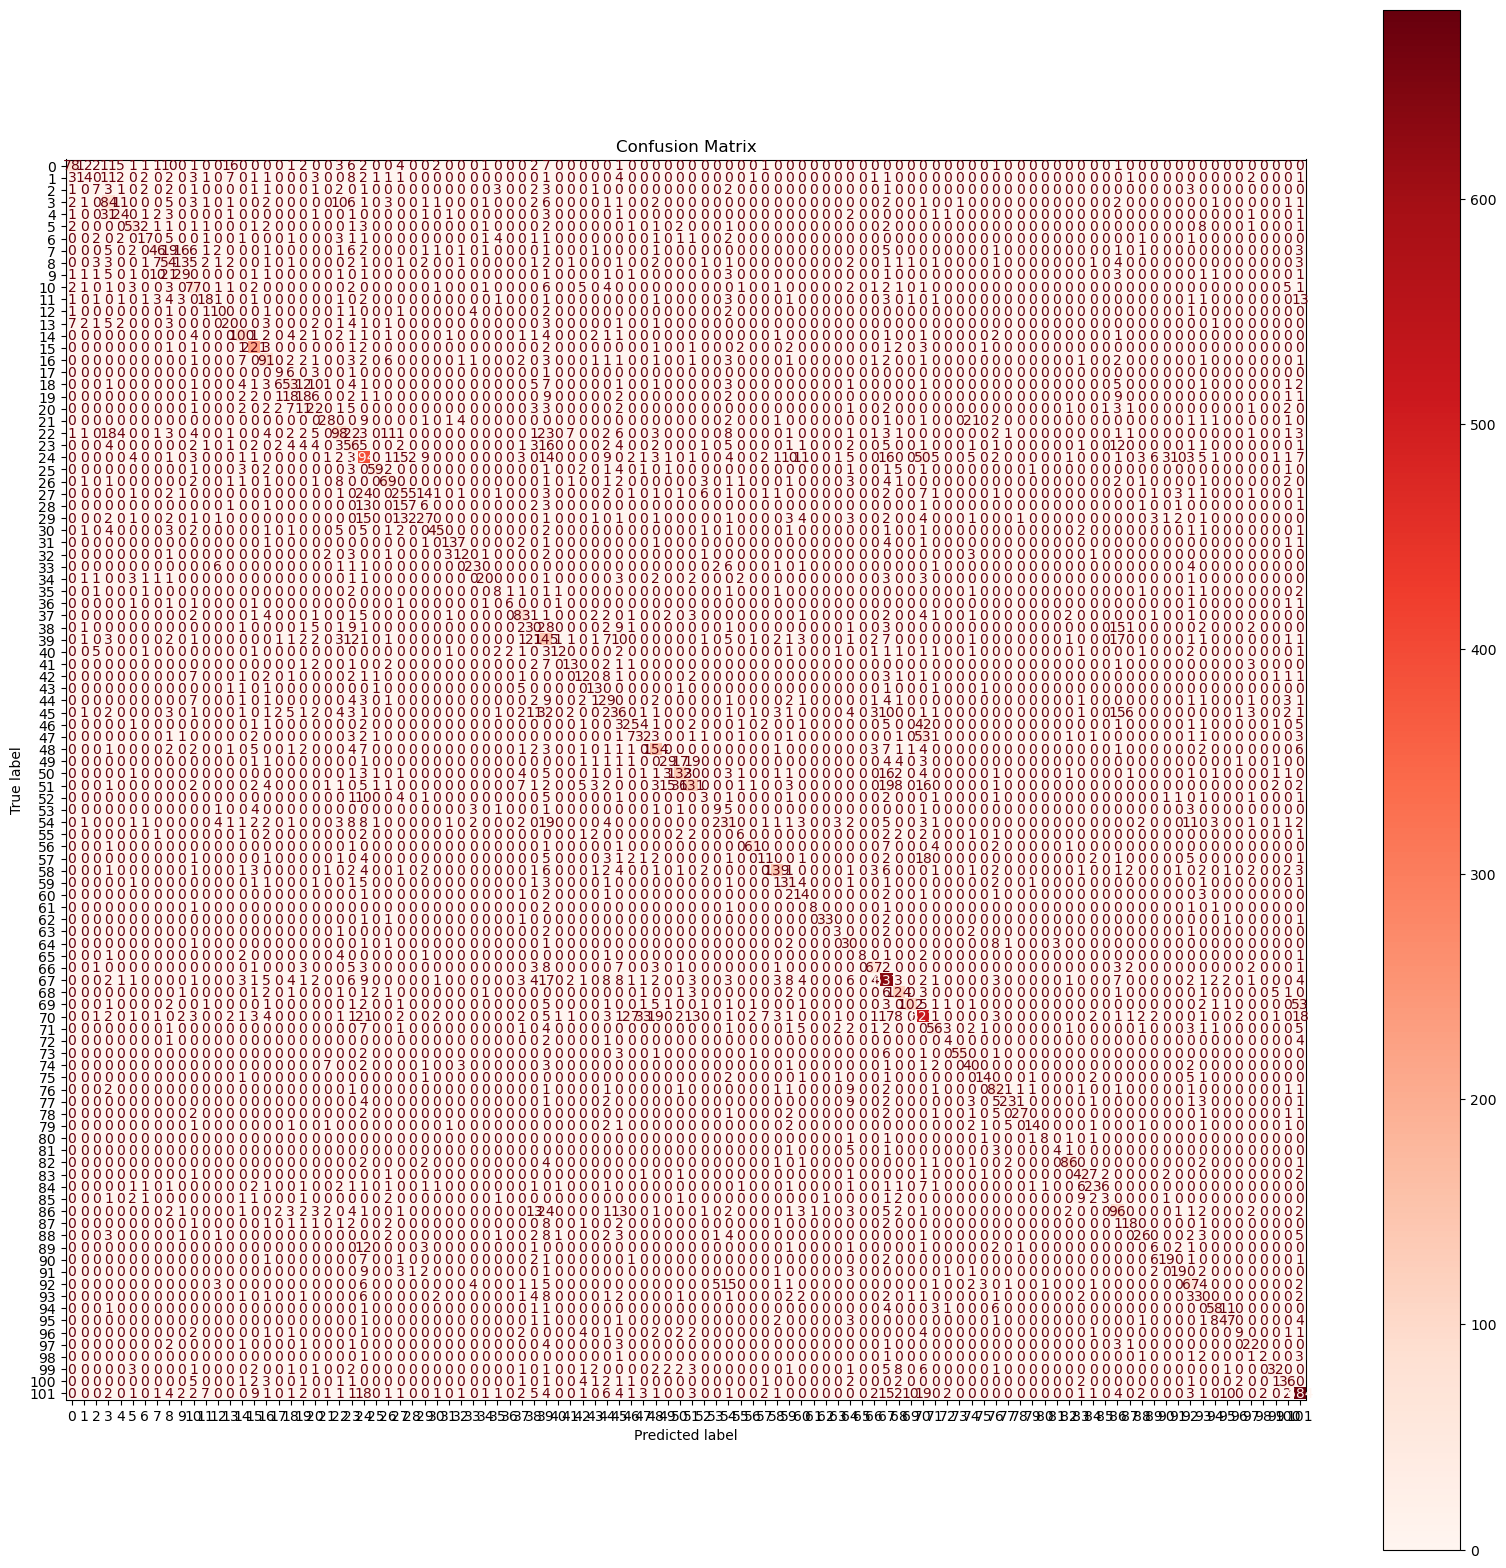

In [28]:
# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(range(num_classes)))
fig, ax = plt.subplots(figsize=(20, 20))  # Increase figsize
cmd.plot(cmap=plt.cm.Reds, ax=ax)
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

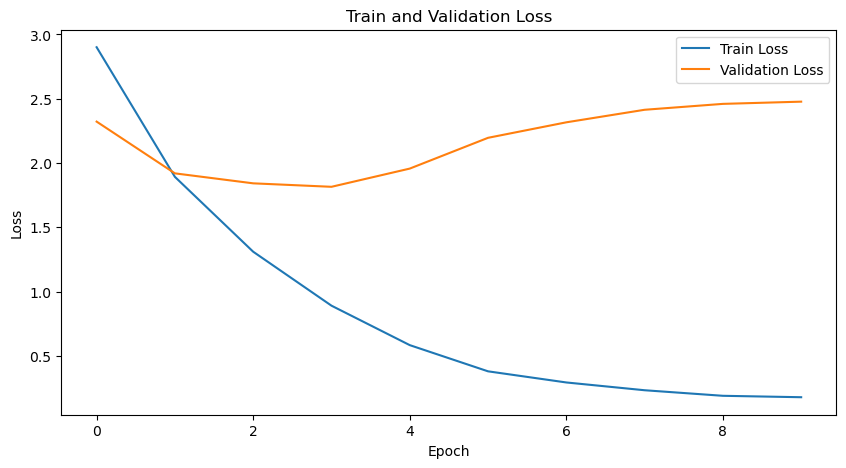

In [29]:
# Plot train and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

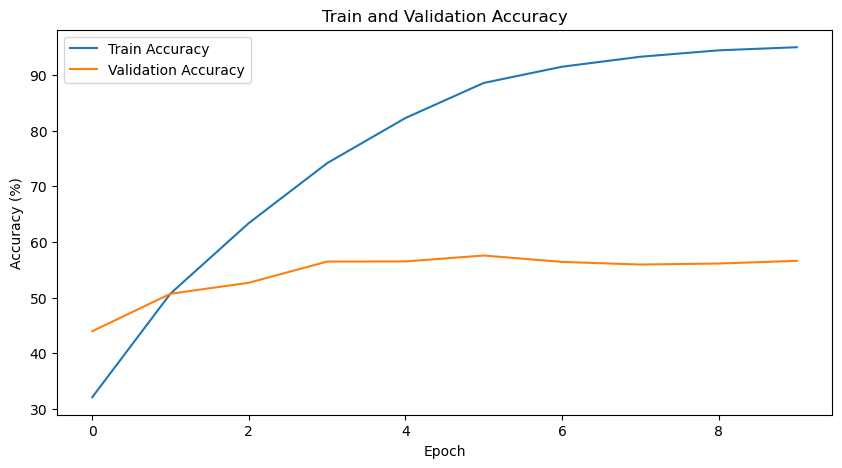

In [30]:
# Plot train and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [31]:
# Print final test results
print('\nFinal Test Results:')
print(f'Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')


Final Test Results:
Test Loss: 2.4737, Accuracy: 55.73%


# After this line are VGG16 using dyanamic leanring rate and data agumentaion cutmix sparese loss



In [2]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import random
class CustomDataset(Dataset):
    def __init__(self, txt_path, img_dir, transform=None, subset_ratio=1.0):
        self.img_dir = img_dir
        self.transform = transform
        self.data = []
        with open(txt_path, 'r') as file:
            lines = file.readlines()
            if subset_ratio < 1.0:
                # 随机选择一部分数据进行训练
                selected_lines = random.sample(lines, int(len(lines) * subset_ratio))
            else:
                selected_lines = lines

            for line in selected_lines:
                path, label = line.strip().split()
                self.data.append((path, int(label)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path, label = self.data[index]
        image = Image.open(os.path.join(self.img_dir, img_path))
        if self.transform:
            image = self.transform(image)
            # 打印看看是否有超出范围的标签
        if label < 0 or label > 102:
            print(f"标签超出范围：{label} at index {index}")
        return image, label

In [3]:

def sparse_loss(model, images):
    """
    Computes the sparse regularization loss for a given model and input images.

    The sparse regularization loss encourages the activations of the model to be sparse,
    promoting the selection of a subset of relevant features and reducing the overall
    complexity of the model.
    """
    loss = 0
    values = images
    for module in model.children():
        if isinstance(module, nn.Linear):
            # Flatten the output of the previous layers before passing to the Linear layer
            values = torch.flatten(values, start_dim=1)
        values = module(values)
        if hasattr(module, 'activation'):  # Assuming that the ReLU6 is used as a named 'activation' attribute
            values = module.activation(values)
        loss += torch.mean(torch.abs(values))  # Calculate L1 norm for sparsity
    return loss


In [4]:
def cutmix(data, targets, alpha=1.0):
    """
    Applies CutMix augmentation to the input data and targets.

    CutMix is a data augmentation technique that combines samples from different inputs by randomly
    selecting a bounding box in one sample and replacing the corresponding region in another sample.
    The targets are also mixed accordingly.

    Args:
        data (torch.Tensor): The input data tensor of shape (batch_size, channels, height, width).
        targets (torch.Tensor): The target tensor of shape (batch_size,) containing the class labels.
        alpha (float, optional): The hyperparameter controlling the strength of the CutMix augmentation.
            Higher values of alpha result in stronger augmentation. Default is 1.0.

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor, float]: A tuple containing the augmented data,
        original targets, shuffled targets, and the lambda value used for mixing.

    """

    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    lam = max(lam, 1 - lam)

    batch_size = data.size(0)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)

    data[:, :, bbx1:bbx2, bby1:bby2] = shuffled_data[:, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size(-1) * data.size(-2)))

    return data, targets, shuffled_targets, lam


def rand_bbox(size, lam):
    """
    Generates random bounding box coordinates based on the size of the input tensor and the lambda value.

    Args:
        size (Tuple[int, int, int, int]): The size of the input tensor (batch_size, channels, height, width).
        lam (float): The lambda value used for determining the size of the bounding box.

    Returns:
        Tuple[int, int, int, int]: A tuple containing the bounding box coordinates (bbx1, bby1, bbx2, bby2).

    """

    width = size[2]
    height = size[3]
    cut_ratio = np.sqrt(1. - lam)
    cut_w = (width * cut_ratio).astype(np.int32)
    cut_h = (height * cut_ratio).astype(np.int32)

    cx = np.random.randint(width)
    cy = np.random.randint(height)

    bbx1 = np.clip(cx - cut_w // 2, 0, width)
    bby1 = np.clip(cy - cut_h // 2, 0, height)
    bbx2 = np.clip(cx + cut_w // 2, 0, width)
    bby2 = np.clip(cy + cut_h // 2, 0, height)

    return bbx1, bby1, bbx2, bby2


Epoch 1, Batch 10, Loss: 4.3170, Accuracy: 6.56%
Epoch 1, Batch 20, Loss: 4.2729, Accuracy: 8.91%
Epoch 1, Batch 30, Loss: 4.3071, Accuracy: 11.04%
Epoch 1, Batch 40, Loss: 3.7186, Accuracy: 12.97%
Epoch 1, Batch 50, Loss: 3.9637, Accuracy: 14.44%
Epoch 1, Batch 60, Loss: 4.0276, Accuracy: 15.31%
Epoch 1, Batch 70, Loss: 3.5178, Accuracy: 16.16%
Epoch 1, Batch 80, Loss: 3.9490, Accuracy: 16.88%
Epoch 1, Batch 90, Loss: 3.7254, Accuracy: 17.92%
Epoch 1, Batch 100, Loss: 3.3496, Accuracy: 18.66%
Epoch 1, Batch 110, Loss: 3.3107, Accuracy: 19.18%
Epoch 1, Batch 120, Loss: 3.4098, Accuracy: 19.95%
Epoch 1, Batch 130, Loss: 3.2589, Accuracy: 20.65%
Epoch 1, Batch 140, Loss: 3.6832, Accuracy: 21.00%
Epoch 1, Batch 150, Loss: 3.3299, Accuracy: 21.35%
Epoch 1, Batch 160, Loss: 2.9928, Accuracy: 21.84%
Epoch 1, Batch 170, Loss: 2.9701, Accuracy: 22.19%
Epoch 1, Batch 180, Loss: 3.6280, Accuracy: 22.47%
Epoch 1, Batch 190, Loss: 2.6218, Accuracy: 22.76%
Epoch 1, Batch 200, Loss: 2.5814, Accuracy

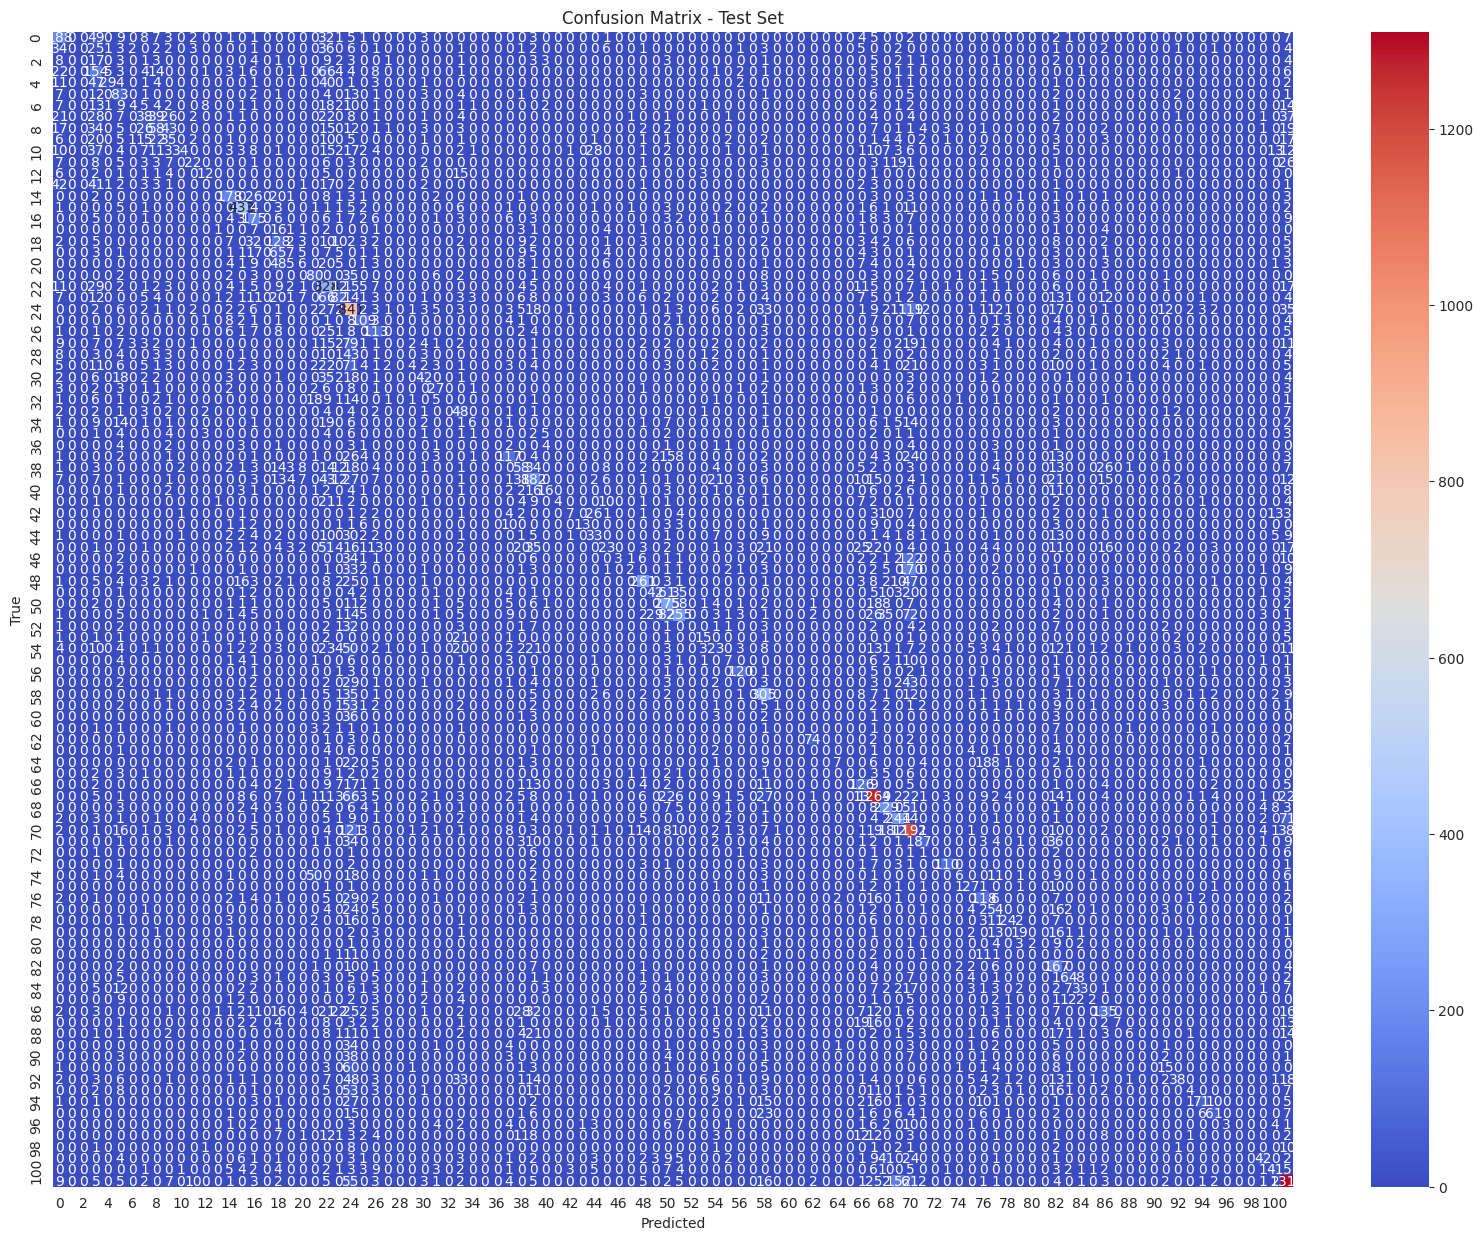

混淆矩阵已保存为 'confusion_matrix.png'
Epoch 2, Batch 10, Loss: 3.3360, Accuracy: 42.19%
Epoch 2, Batch 20, Loss: 1.6570, Accuracy: 45.00%
Epoch 2, Batch 30, Loss: 3.5681, Accuracy: 45.31%
Epoch 2, Batch 40, Loss: 2.9046, Accuracy: 44.92%
Epoch 2, Batch 50, Loss: 1.5204, Accuracy: 44.88%
Epoch 2, Batch 60, Loss: 1.9660, Accuracy: 43.96%
Epoch 2, Batch 70, Loss: 2.3569, Accuracy: 43.48%
Epoch 2, Batch 80, Loss: 2.1789, Accuracy: 43.36%
Epoch 2, Batch 90, Loss: 2.4114, Accuracy: 43.75%
Epoch 2, Batch 100, Loss: 2.8481, Accuracy: 43.56%
Epoch 2, Batch 110, Loss: 3.2524, Accuracy: 42.98%
Epoch 2, Batch 120, Loss: 1.9276, Accuracy: 42.86%
Epoch 2, Batch 130, Loss: 2.3517, Accuracy: 42.31%
Epoch 2, Batch 140, Loss: 2.3399, Accuracy: 42.39%
Epoch 2, Batch 150, Loss: 3.1059, Accuracy: 41.98%
Epoch 2, Batch 160, Loss: 2.3401, Accuracy: 41.58%
Epoch 2, Batch 170, Loss: 3.6790, Accuracy: 41.54%
Epoch 2, Batch 180, Loss: 2.1077, Accuracy: 41.60%
Epoch 2, Batch 190, Loss: 2.3004, Accuracy: 41.71%
Epoch 2,

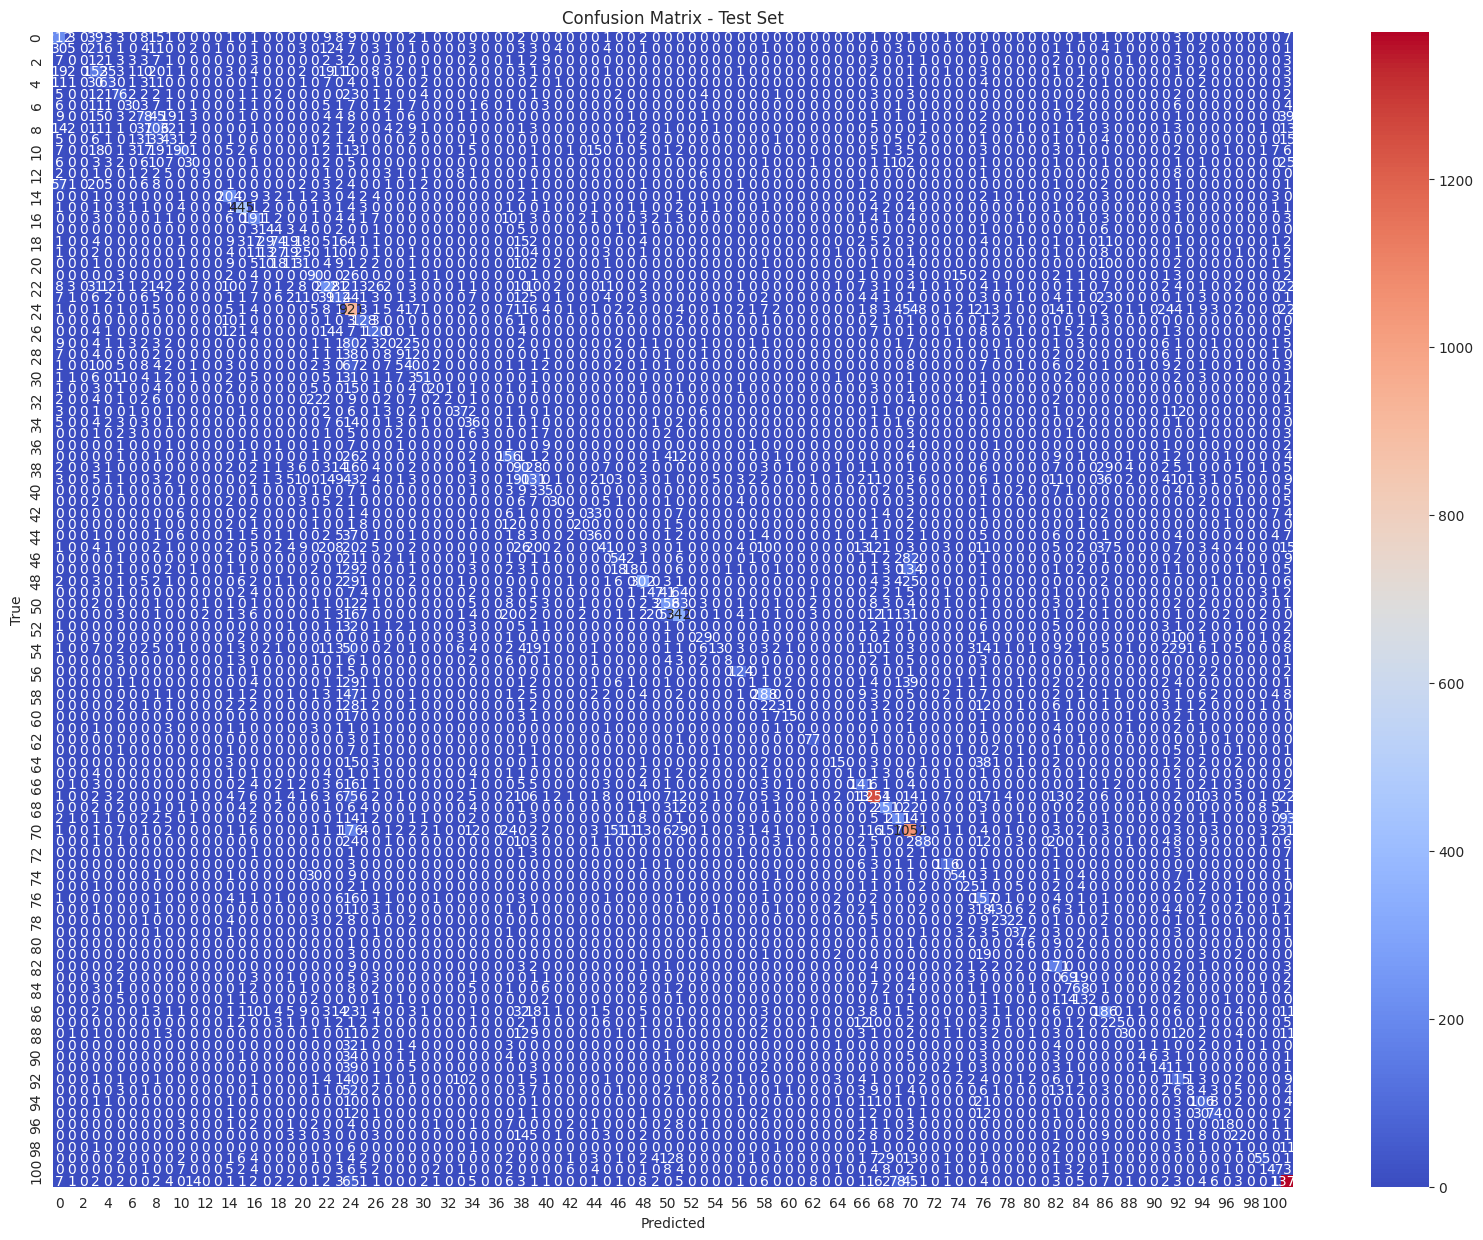

混淆矩阵已保存为 'confusion_matrix.png'
Epoch 3, Batch 10, Loss: 2.0405, Accuracy: 57.19%
Epoch 3, Batch 20, Loss: 2.2508, Accuracy: 55.78%
Epoch 3, Batch 30, Loss: 2.1672, Accuracy: 55.52%
Epoch 3, Batch 40, Loss: 2.0742, Accuracy: 53.67%
Epoch 3, Batch 50, Loss: 3.3030, Accuracy: 52.25%
Epoch 3, Batch 60, Loss: 1.7091, Accuracy: 51.88%
Epoch 3, Batch 70, Loss: 1.8394, Accuracy: 51.96%
Epoch 3, Batch 80, Loss: 2.1385, Accuracy: 51.48%
Epoch 3, Batch 90, Loss: 3.0076, Accuracy: 51.81%
Epoch 3, Batch 100, Loss: 2.5353, Accuracy: 52.25%
Epoch 3, Batch 110, Loss: 1.3373, Accuracy: 52.76%
Epoch 3, Batch 120, Loss: 3.2398, Accuracy: 51.80%
Epoch 3, Batch 130, Loss: 3.2494, Accuracy: 51.54%
Epoch 3, Batch 140, Loss: 1.6990, Accuracy: 50.94%
Epoch 3, Batch 150, Loss: 2.7546, Accuracy: 51.27%
Epoch 3, Batch 160, Loss: 2.1738, Accuracy: 52.09%
Epoch 3, Batch 170, Loss: 1.5263, Accuracy: 52.15%
Epoch 3, Batch 180, Loss: 3.1501, Accuracy: 52.20%
Epoch 3, Batch 190, Loss: 2.0113, Accuracy: 51.74%
Epoch 3,

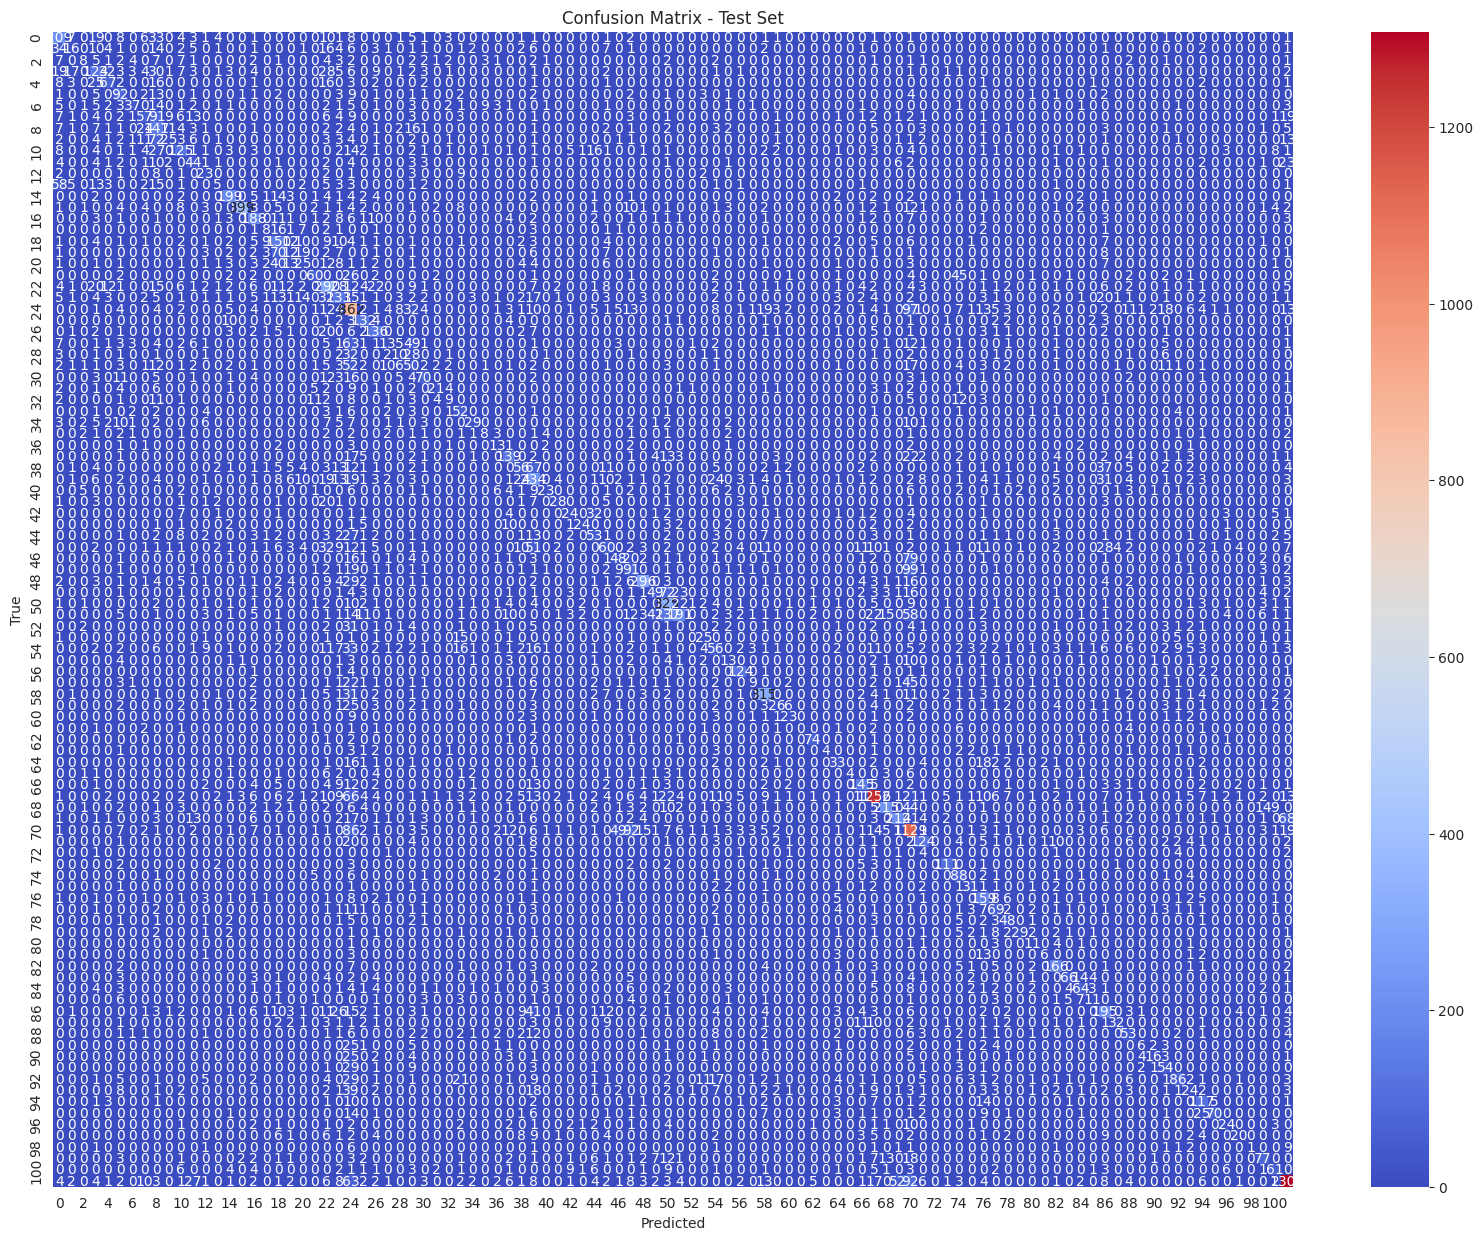

混淆矩阵已保存为 'confusion_matrix.png'
Epoch 4, Batch 10, Loss: 2.3848, Accuracy: 59.06%
Epoch 4, Batch 20, Loss: 2.6494, Accuracy: 54.22%
Epoch 4, Batch 30, Loss: 2.8655, Accuracy: 53.96%
Epoch 4, Batch 40, Loss: 0.9053, Accuracy: 54.22%
Epoch 4, Batch 50, Loss: 1.0985, Accuracy: 55.62%
Epoch 4, Batch 60, Loss: 1.8537, Accuracy: 56.61%
Epoch 4, Batch 70, Loss: 1.8039, Accuracy: 58.04%
Epoch 4, Batch 80, Loss: 2.6147, Accuracy: 58.75%
Epoch 4, Batch 90, Loss: 2.3267, Accuracy: 58.99%
Epoch 4, Batch 100, Loss: 3.4082, Accuracy: 58.28%
Epoch 4, Batch 110, Loss: 1.6780, Accuracy: 58.66%
Epoch 4, Batch 120, Loss: 1.8672, Accuracy: 58.70%
Epoch 4, Batch 130, Loss: 2.5622, Accuracy: 58.20%
Epoch 4, Batch 140, Loss: 2.2820, Accuracy: 58.44%
Epoch 4, Batch 150, Loss: 3.3320, Accuracy: 58.48%
Epoch 4, Batch 160, Loss: 2.2105, Accuracy: 59.10%
Epoch 4, Batch 170, Loss: 2.6215, Accuracy: 58.88%
Epoch 4, Batch 180, Loss: 1.6957, Accuracy: 58.87%
Epoch 4, Batch 190, Loss: 1.9782, Accuracy: 58.63%
Epoch 4,

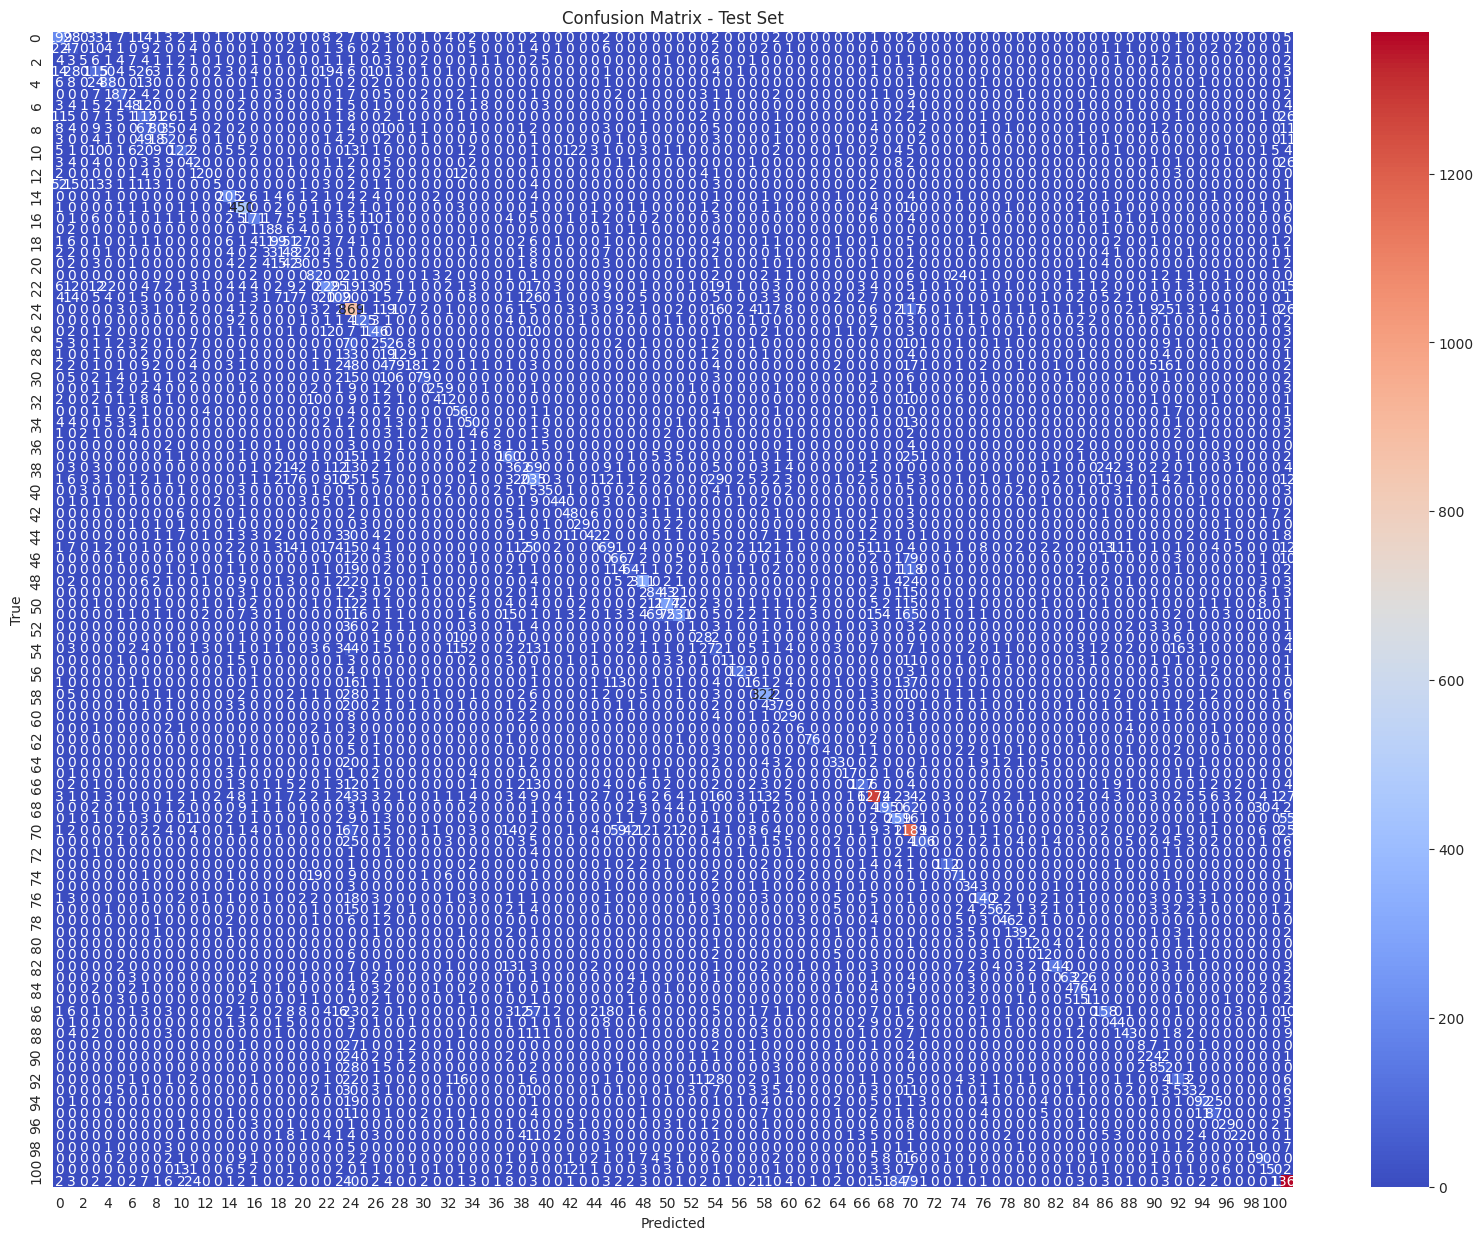

混淆矩阵已保存为 'confusion_matrix.png'
Epoch 5, Batch 10, Loss: 0.6082, Accuracy: 76.56%
Epoch 5, Batch 20, Loss: 1.8617, Accuracy: 75.62%
Epoch 5, Batch 30, Loss: 1.4255, Accuracy: 75.73%
Epoch 5, Batch 40, Loss: 1.8426, Accuracy: 74.06%
Epoch 5, Batch 50, Loss: 3.5261, Accuracy: 72.00%
Epoch 5, Batch 60, Loss: 1.6342, Accuracy: 71.15%
Epoch 5, Batch 70, Loss: 2.6962, Accuracy: 70.22%
Epoch 5, Batch 80, Loss: 1.1960, Accuracy: 69.41%
Epoch 5, Batch 90, Loss: 2.2745, Accuracy: 68.23%
Epoch 5, Batch 100, Loss: 2.2998, Accuracy: 67.53%
Epoch 5, Batch 110, Loss: 2.2695, Accuracy: 68.12%
Epoch 5, Batch 120, Loss: 2.6513, Accuracy: 67.45%
Epoch 5, Batch 130, Loss: 1.2364, Accuracy: 66.61%
Epoch 5, Batch 140, Loss: 3.4546, Accuracy: 65.92%
Epoch 5, Batch 150, Loss: 1.3567, Accuracy: 66.35%
Epoch 5, Batch 160, Loss: 2.1594, Accuracy: 66.74%
Epoch 5, Batch 170, Loss: 2.3080, Accuracy: 66.69%
Epoch 5, Batch 180, Loss: 2.4346, Accuracy: 66.15%
Epoch 5, Batch 190, Loss: 1.8743, Accuracy: 65.99%
Epoch 5,

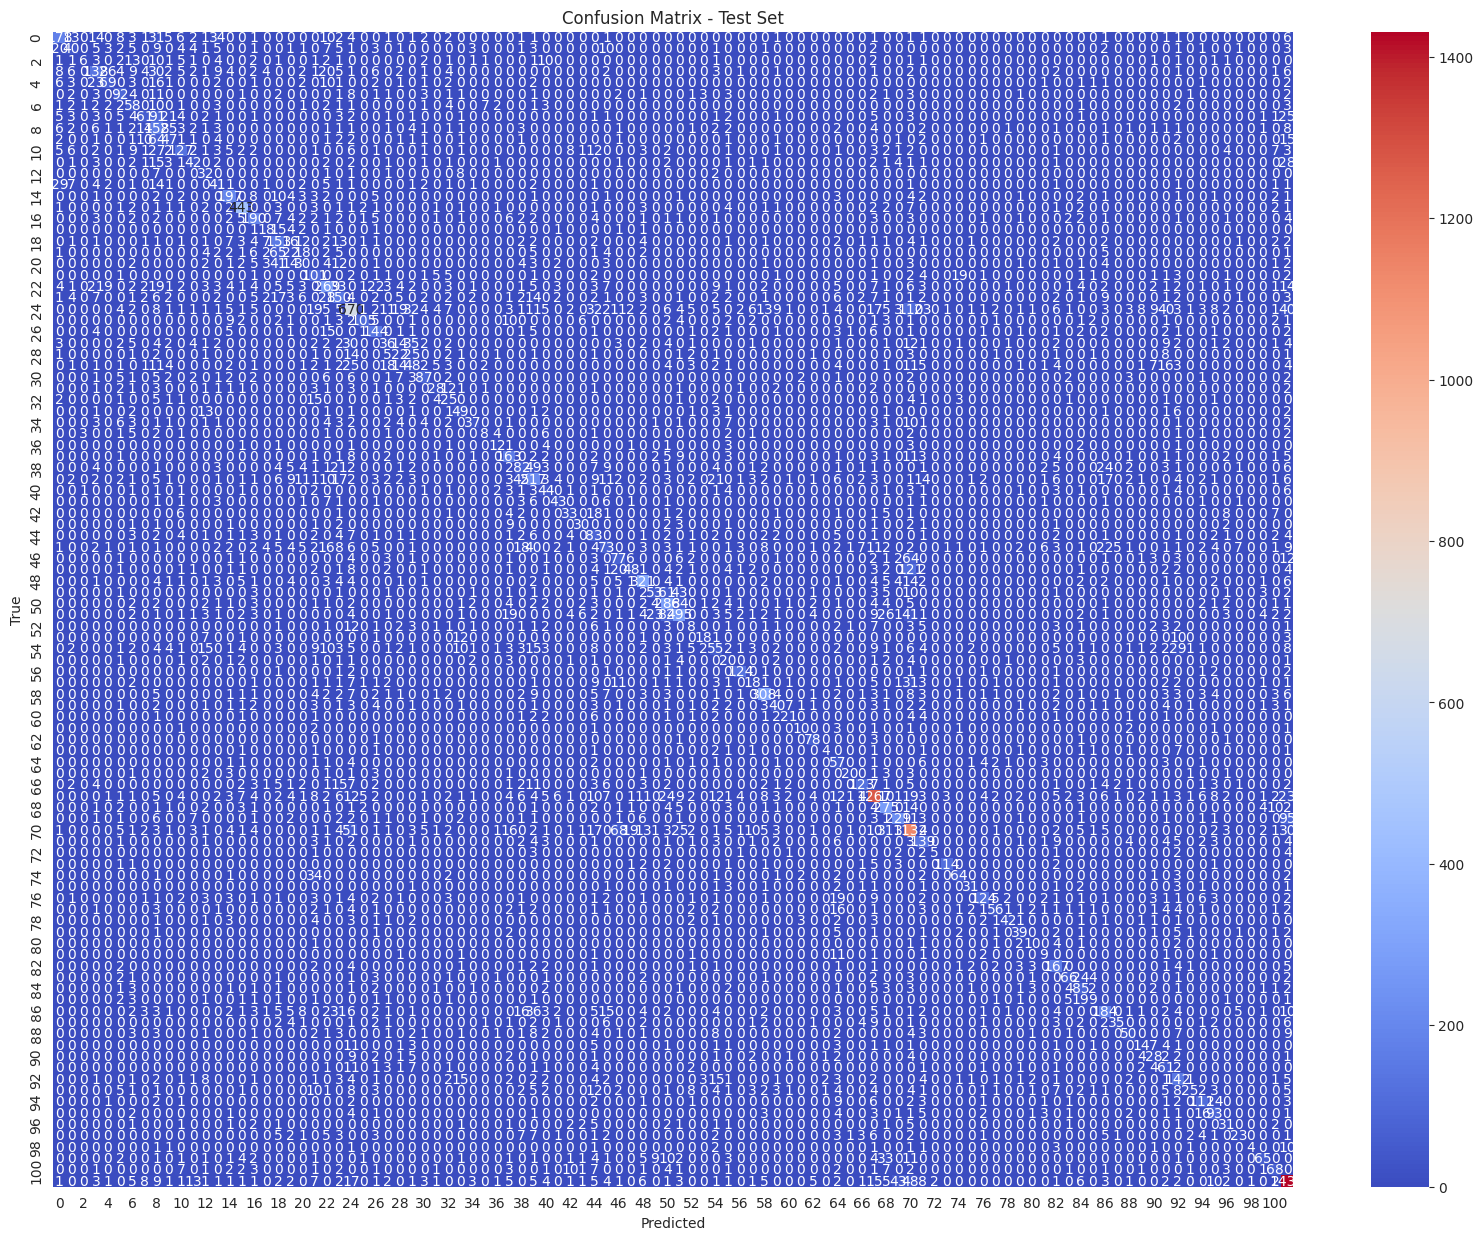

混淆矩阵已保存为 'confusion_matrix.png'
Epoch 6, Batch 10, Loss: 2.8612, Accuracy: 65.94%
Epoch 6, Batch 20, Loss: 1.9971, Accuracy: 66.41%
Epoch 6, Batch 30, Loss: 1.7715, Accuracy: 66.46%
Epoch 6, Batch 40, Loss: 0.4992, Accuracy: 68.44%
Epoch 6, Batch 50, Loss: 2.0978, Accuracy: 67.69%
Epoch 6, Batch 60, Loss: 3.1609, Accuracy: 65.78%
Epoch 6, Batch 70, Loss: 2.8259, Accuracy: 66.38%
Epoch 6, Batch 80, Loss: 1.5135, Accuracy: 67.11%
Epoch 6, Batch 90, Loss: 0.6533, Accuracy: 67.64%
Epoch 6, Batch 100, Loss: 2.5198, Accuracy: 68.50%
Epoch 6, Batch 110, Loss: 1.5271, Accuracy: 69.32%
Epoch 6, Batch 120, Loss: 2.3192, Accuracy: 69.24%
Epoch 6, Batch 130, Loss: 1.7882, Accuracy: 68.85%
Epoch 6, Batch 140, Loss: 1.3418, Accuracy: 68.86%
Epoch 6, Batch 150, Loss: 1.6965, Accuracy: 68.29%
Epoch 6, Batch 160, Loss: 2.9474, Accuracy: 68.36%
Epoch 6, Batch 170, Loss: 1.9806, Accuracy: 68.64%
Epoch 6, Batch 180, Loss: 3.2270, Accuracy: 68.68%
Epoch 6, Batch 190, Loss: 0.9797, Accuracy: 68.55%
Epoch 6,

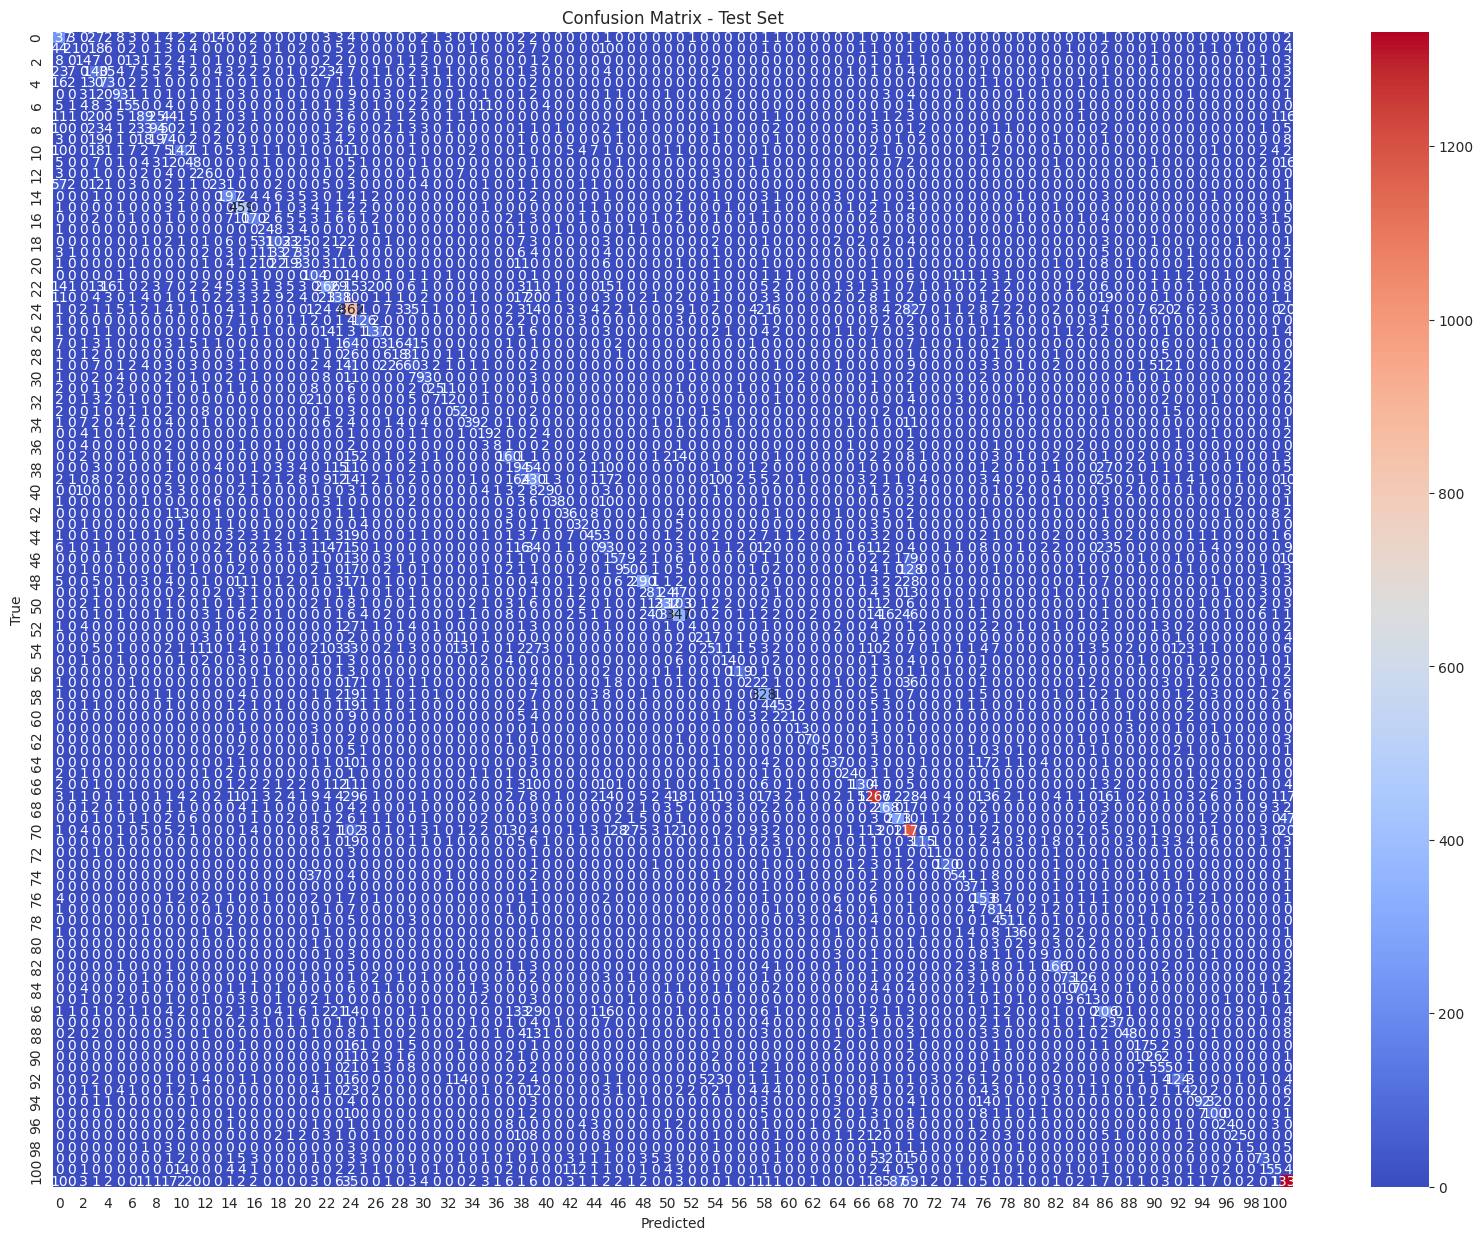

混淆矩阵已保存为 'confusion_matrix.png'


In [6]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights


import time
from torch.optim.lr_scheduler import StepLR 
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# from evaluate import evaluate
import os

# set device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# data transform 
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB')),  # sure the image is RGB
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize the image
])

# create dataset 
train_dataset = CustomDataset(txt_path='train.txt', img_dir='images/', transform=transform, subset_ratio=0.5)
val_dataset = CustomDataset(txt_path='val.txt', img_dir='images/', transform=transform)
test_dataset = CustomDataset(txt_path='test.txt', img_dir='images/', transform=transform)

# create data_loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# initialise model 
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
for param in model.features.parameters():  # freeze the feature layers
    param.requires_grad = False

num_classes = 102
model.classifier[6] = nn.Linear(4096, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
writer = SummaryWriter('runs/experiment_name')  
def train(model, train_loader, val_loader, test_loader, num_epochs, alpha=1.0):
    optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=0.0001)  # using adamW optimizer
    scheduler= StepLR(optimizer, step_size=50, gamma=0.1) 

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        total_loss = 0
        total = correct = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            if np.random.rand() < 0.8:  
                images, targets_a, targets_b, lam = cutmix(images, labels, alpha)
                outputs = model(images)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)


            reg_loss = sparse_loss(model, images)
            total_loss = loss + 0.001 * reg_loss  

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            optimizer.zero_grad()
            total_loss.backward()
            loss.backward()
            optimizer.step()

            if (batch_idx + 1) % 10 == 0:
                accuracy = 100 * correct / total
                print(f'Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {total_loss.item():.4f}, Accuracy: {accuracy:.2f}%')
                # writing to tensorboard
                writer.add_scalar('Loss/train', total_loss.item(), epoch * len(train_loader) + batch_idx)
                writer.add_scalar('Accuracy/train', accuracy, epoch * len(train_loader) + batch_idx)
        elapsed_time = time.time() - start_time
        print(f'Epoch {epoch + 1} completed in {elapsed_time:.2f} seconds')

        scheduler.step()  # update learning rate

        model.eval()
        val_accuracy, _, _ = evaluate(model, val_loader)
        # val_accuracy = evaluate(model, val_loader)
        writer.add_scalar('Validation Accuracy', val_accuracy, global_step=epoch)

        # Testing phase
        # test_accuracy = evaluate(model, test_loader)
        test_accuracy, test_preds, test_labels = evaluate(model, test_loader)
        writer.add_scalar('Test Accuracy', test_accuracy, global_step=epoch)

        print(
            f'Epoch {epoch + 1}/{num_epochs} - Train Acc: {accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}% in {elapsed_time:.2f} sec')

        cm = confusion_matrix(test_labels, test_preds)
        plt.figure(figsize=(20, 15))
        sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=True)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix - Test Set')
        plt.savefig('confusion_matrix.png') 
        plt.show() 

        print("混淆矩阵已保存为 'confusion_matrix.png'")

def evaluate(model, loader):
    total = correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = 100 * correct / total
    return accuracy, all_preds, all_labels


# Usage example:
train(model, train_loader, val_loader, test_loader, num_epochs=6, alpha=1.0)


In [ ]:
#after this line are the code from the original paper not complet and shows accuracy in the last pictures it's cited from the paper not our work before this line all do by ourselves.

In [ ]:
from typing import Any

import torch
# from .components.cutmix import cutmix
# from .components.sparse_regularization import sparse_loss
# from .components.insect_pest_net import InsectPestClassifier
# from lightning import LightningModule
import lightning.pytorch as pl
from torchmetrics import MaxMetric, MeanMetric
from torchmetrics.classification.accuracy import Accuracy


class InsectPestLitModule(pl.LightningModule):
    """LightningModule implementation for training and evaluating an insect pest classifier.

    Args:
       net (torch.nn.Module, optional): The neural network model. If not provided, a default
           InsectPestClassifier model will be used. Default is None.
       optimizer (torch.optim.Optimizer, optional): The optimizer for training the model. Default
           is torch.optim.Adam.
       scheduler (torch.optim.lr_scheduler, optional): The learning rate scheduler for adjusting the
           learning rate during training. Default is torch.optim.lr_scheduler.ReduceLROnPlateau.
       num_classes (int, optional): The number of classes in the classification task. Default is 102.
       freeze (bool, optional): Flag indicating whether to freeze the weights of the model during training.
           Default is True.

    Attributes:
       net (torch.nn.Module): The neural network model.
       criterion (torch.nn.CrossEntropyLoss): The loss function for the classifier.
       train_acc (Accuracy): Metric object for calculating and averaging accuracy during training.
       val_acc (Accuracy): Metric object for calculating and averaging accuracy during validation.
       test_acc (Accuracy): Metric object for calculating and averaging accuracy during testing.
       train_loss (MeanMetric): Metric object for averaging loss during training.
       val_loss (MeanMetric): Metric object for averaging loss during validation.
       test_loss (MeanMetric): Metric object for averaging loss during testing.
       val_acc_best (MaxMetric): Metric object for tracking the best validation accuracy so far.

    Methods:
       forward(x: torch.Tensor) -> torch.Tensor:
           Performs a forward pass through the network.
       on_train_start():
           Callback function called at the beginning of the training.
       model_step(batch: Any, apply_cutmix: bool = False) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
           Performs a single step in the training/validation/test process.
       training_step(batch: Any, batch_idx: int) -> torch.Tensor:
           Performs a training step on a batch of data.
       on_train_epoch_end():
           Callback function called at the end of each training epoch.
       validation_step(batch: Any, batch_idx: int):
           Performs a validation step on a batch of data.
       on_validation_epoch_end():
           Callback function called at the end of each validation epoch.
       test_step(batch: Any, batch_idx: int):
           Performs a test step on a batch of data.
       on_test_epoch_end():
           Callback function called at the end of each testing epoch.
       configure_optimizers() -> Union[Dict, Tuple]:
           Configures the optimizers and learning rate schedulers for the training process.
   """

    def __init__(
            self,
            net: torch.nn.Module = None,
            optimizer: torch.optim.Optimizer = torch.optim.Adam,
            scheduler: torch.optim.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau,
            num_classes: int = 102,
            freeze: bool = True,
    ):
        super().__init__()

        if net is None:
            net = InsectPestClassifier(output_size=num_classes, freeze=freeze)

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)

        self.net = net

        # loss function
        self.criterion = torch.nn.CrossEntropyLoss()

        # metric objects for calculating and averaging accuracy across batches
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)

        # for averaging loss across batches
        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

        # for tracking best so far validation accuracy
        self.val_acc_best = MaxMetric()

    def forward(self, x: torch.Tensor):
        return self.net(x)

    def on_train_start(self):
        # by default lightning executes validation step sanity checks before training starts,
        # so it's worth to make sure validation metrics don't store results from these checks
        self.val_loss.reset()
        self.val_acc.reset()
        self.val_acc_best.reset()

    def model_step(self, batch: Any, apply_cutmix: bool = False):
        x, y = batch
        if apply_cutmix:
            x_cutmix, y_a, y_b, lam = cutmix(x, y, alpha=1.0)  # Apply CutMix
            logits = self.forward(x_cutmix)
            loss = lam * self.criterion(logits, y_a) + (1 - lam) * self.criterion(logits, y_b)  # CutMix loss
        else:
            logits = self.forward(x)
            loss = self.criterion(logits, y)  # Original loss

        preds = torch.argmax(logits, dim=1)
        return loss, preds, y

    def training_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.model_step(batch, apply_cutmix=True)

        sparse_reg_loss = sparse_loss(self.net, batch[0])  # Sparse regularization loss
        loss += 0.001 * sparse_reg_loss  # Add sparse regularization loss to the total loss

        # update and log metrics
        self.train_loss(loss)
        self.train_acc(preds, targets)
        self.log("train/loss", self.train_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train/acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True)

        # return loss or backpropagation will fail
        return loss

    def on_train_epoch_end(self):
        pass

    def validation_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.model_step(batch, apply_cutmix=False)

        # update and log metrics
        self.val_loss(loss)
        self.val_acc(preds, targets)
        self.log("val/loss", self.val_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/acc", self.val_acc, on_step=False, on_epoch=True, prog_bar=True)

    def on_validation_epoch_end(self):
        acc = self.val_acc.compute()  # get current val acc
        self.val_acc_best(acc)  # update best so far val acc
        # log `val_acc_best` as a value through `.compute()` method, instead of as a metric object
        # otherwise metric would be reset by lightning after each epoch
        self.log("val/acc_best", self.val_acc_best.compute(), sync_dist=True, prog_bar=True)

    def test_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.model_step(batch)

        # update and log metrics
        self.test_loss(loss)
        self.test_acc(preds, targets)
        self.log("test/loss", self.test_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test/acc", self.test_acc, on_step=False, on_epoch=True, prog_bar=True)

    def on_test_epoch_end(self):
        pass

    def configure_optimizers(self):
        """Choose what optimizers and learning-rate schedulers to use in your optimization.
        Normally you'd need one. But in the case of GANs or similar you might have multiple.

        Examples:
            https://lightning.ai/docs/pytorch/latest/common/lightning_module.html#configure-optimizers
        """
        optimizer = self.hparams.optimizer(params=self.parameters())
        if self.hparams.scheduler is not None:
            scheduler = self.hparams.scheduler(optimizer=optimizer)
            return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": "val/loss",
                    "interval": "epoch",
                    "frequency": 1,
                },
            }
        return {"optimizer": optimizer}


if __name__ == "__main__":
    _ = InsectPestLitModule(None, None, None)
import nbformat

def merge_notebooks(notebooks, output_file):

    merged_notebook = nbformat.v4.new_notebook(metadata={"name": "merged_notebook9444ID01"})

    for nb_path in notebooks:
        with open(nb_path, 'r', encoding='utf-8') as f:
            nb = nbformat.read(f, as_version=4) 

            merged_notebook.cells.extend(nb.cells)


    with open(output_file, 'w', encoding='utf-8') as f:
        nbformat.write(merged_notebook, f)


notebooks_to_merge = ['test1.ipynb', 'test2.ipynb']

output_file = 'merged_notebook.ipynb'


merge_notebooks(notebooks_to_merge, output_file)


In [ ]:
import torch
import numpy as np

def cutmix(data, targets, alpha=1.0):
    """
    Applies CutMix augmentation to the input data and targets.

    CutMix is a data augmentation technique that combines samples from different inputs by randomly
    selecting a bounding box in one sample and replacing the corresponding region in another sample.
    The targets are also mixed accordingly.

    Args:
        data (torch.Tensor): The input data tensor of shape (batch_size, channels, height, width).
        targets (torch.Tensor): The target tensor of shape (batch_size,) containing the class labels.
        alpha (float, optional): The hyperparameter controlling the strength of the CutMix augmentation.
            Higher values of alpha result in stronger augmentation. Default is 1.0.

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor, float]: A tuple containing the augmented data,
        original targets, shuffled targets, and the lambda value used for mixing.

    """
    
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    lam = max(lam, 1 - lam)

    batch_size = data.size(0)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)

    data[:, :, bbx1:bbx2, bby1:bby2] = shuffled_data[:, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size(-1) * data.size(-2)))

    return data, targets, shuffled_targets, lam

def rand_bbox(size, lam):
    """
    Generates random bounding box coordinates based on the size of the input tensor and the lambda value.

    Args:
        size (Tuple[int, int, int, int]): The size of the input tensor (batch_size, channels, height, width).
        lam (float): The lambda value used for determining the size of the bounding box.

    Returns:
        Tuple[int, int, int, int]: A tuple containing the bounding box coordinates (bbx1, bby1, bbx2, bby2).

    """
    
    width = size[2]
    height = size[3]
    cut_ratio = np.sqrt(1. - lam)
    cut_w = (width * cut_ratio).astype(np.int32)
    cut_h = (height * cut_ratio).astype(np.int32)

    cx = np.random.randint(width)
    cy = np.random.randint(height)

    bbx1 = np.clip(cx - cut_w // 2, 0, width)
    bby1 = np.clip(cy - cut_h // 2, 0, height)
    bbx2 = np.clip(cx + cut_w // 2, 0, width)
    bby2 = np.clip(cy + cut_h // 2, 0, height)

    return bbx1, bby1, bbx2, bby2


In [ ]:
import torch
import torch.nn.functional as F

def sparse_loss(model, images):
    """
    Computes the sparse regularization loss for a given model and input images.

    The sparse regularization loss encourages the activations of the model to be sparse, promoting
    the selection of a subset of relevant features and reducing the overall complexity of the model.

    Args:
        model (torch.nn.Module): The neural network model.
        images (torch.Tensor): The input images tensor of shape (batch_size, channels, height, width).

    Returns:
        torch.Tensor: The sparse regularization loss as a scalar tensor.

    """
    
    loss = 0
    values = images
    for module in model.children():
        values = F.relu6(module(values))
        loss += torch.mean(torch.abs(values))
    return loss


In [ ]:
# from .mobilenetv2 import mobilenetV2
from torch import nn


def mobilenetV2(pretrained):
    pass


class InsectPestClassifier(nn.Module):
    """
    A classifier model based on MobileNetV2 architecture for insect pest recognition.

    The InsectPestClassifier is a neural network model that utilizes MobileNetV2 as its base
    feature extractor and adds additional fully connected layers for classification. The model
    can be optionally frozen to prevent updating the weights of the base feature extractor during
    training.

    Args:
        input_size (int, optional): The number of input features to the classifier. Default is 1280.
        linear1_size (int, optional): The number of units in the first fully connected layer. Default is 1024.
        linear2_size (int, optional): The number of units in the second fully connected layer. Default is 512.
        linear3_size (int, optional): The number of units in the third fully connected layer. Default is 256.
        output_size (int, optional): The number of output classes. Default is 102.
        dropout_size (float, optional): The dropout probability for the fully connected layers. Default is 0.2.
        freeze (bool, optional): Flag indicating whether to freeze the weights of the base feature extractor.
            If True, the weights are frozen; if False, the weights are trainable. Default is True.

    Attributes:
        mobilenet (nn.Module): The MobileNetV2 base feature extractor.
    
    Methods:
        forward(x: torch.Tensor) -> torch.Tensor:
            Performs a forward pass through the network.
        freeze():
            Freezes the weights of the base feature extractor.
        unfreeze():
            Unfreezes the weights of the base feature extractor.
    """
    
    def __init__(
            self,
            input_size: int = 1280,
            linear1_size: int = 1024,
            linear2_size: int = 512,
            linear3_size: int = 256,
            output_size: int = 102,
            dropout_size: float = 0.2,
            freeze: bool = True

        ):
        super().__init__()

        self.mobilenet = mobilenetV2(pretrained=True)
        
        if freeze:
            self.freeze()
        else:
            self.unfreeze()
        
        self.mobilenet.classifier = nn.Sequential(
            nn.Linear(input_size, linear1_size),
            nn.ReLU(),
            nn.Dropout(dropout_size),

            nn.Linear(linear1_size, linear2_size),
            nn.ReLU(),
            nn.Dropout(dropout_size),

            nn.Linear(linear2_size, linear3_size),
            nn.ReLU(),
            nn.Dropout(dropout_size),

            nn.Linear(linear3_size, output_size)
        )
        
    def forward(self, x):
        return self.mobilenet(x)
    
    def freeze(self):
        for param in self.mobilenet.parameters():
            param.requires_grad = False
        
    def unfreeze(self):
        for param in self.mobilenet.parameters():
            param.requires_grad = True


In [ ]:
from typing import Any

import torch
# from .components.cutmix import cutmix
# from .components.sparse_regularization import sparse_loss
# from .components.insect_pest_net import InsectPestClassifier
# from lightning import LightningModule
import lightning.pytorch as pl
from torchmetrics import MaxMetric, MeanMetric
from torchmetrics.classification.accuracy import Accuracy


class InsectPestLitModule(pl.LightningModule):
    """LightningModule implementation for training and evaluating an insect pest classifier.

    Args:
       net (torch.nn.Module, optional): The neural network model. If not provided, a default
           InsectPestClassifier model will be used. Default is None.
       optimizer (torch.optim.Optimizer, optional): The optimizer for training the model. Default
           is torch.optim.Adam.
       scheduler (torch.optim.lr_scheduler, optional): The learning rate scheduler for adjusting the
           learning rate during training. Default is torch.optim.lr_scheduler.ReduceLROnPlateau.
       num_classes (int, optional): The number of classes in the classification task. Default is 102.
       freeze (bool, optional): Flag indicating whether to freeze the weights of the model during training.
           Default is True.

    Attributes:
       net (torch.nn.Module): The neural network model.
       criterion (torch.nn.CrossEntropyLoss): The loss function for the classifier.
       train_acc (Accuracy): Metric object for calculating and averaging accuracy during training.
       val_acc (Accuracy): Metric object for calculating and averaging accuracy during validation.
       test_acc (Accuracy): Metric object for calculating and averaging accuracy during testing.
       train_loss (MeanMetric): Metric object for averaging loss during training.
       val_loss (MeanMetric): Metric object for averaging loss during validation.
       test_loss (MeanMetric): Metric object for averaging loss during testing.
       val_acc_best (MaxMetric): Metric object for tracking the best validation accuracy so far.

    Methods:
       forward(x: torch.Tensor) -> torch.Tensor:
           Performs a forward pass through the network.
       on_train_start():
           Callback function called at the beginning of the training.
       model_step(batch: Any, apply_cutmix: bool = False) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
           Performs a single step in the training/validation/test process.
       training_step(batch: Any, batch_idx: int) -> torch.Tensor:
           Performs a training step on a batch of data.
       on_train_epoch_end():
           Callback function called at the end of each training epoch.
       validation_step(batch: Any, batch_idx: int):
           Performs a validation step on a batch of data.
       on_validation_epoch_end():
           Callback function called at the end of each validation epoch.
       test_step(batch: Any, batch_idx: int):
           Performs a test step on a batch of data.
       on_test_epoch_end():
           Callback function called at the end of each testing epoch.
       configure_optimizers() -> Union[Dict, Tuple]:
           Configures the optimizers and learning rate schedulers for the training process.
   """

    def __init__(
            self,
            net: torch.nn.Module = None,
            optimizer: torch.optim.Optimizer = torch.optim.Adam,
            scheduler: torch.optim.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau,
            num_classes: int = 102,
            freeze: bool = True,
    ):
        super().__init__()

        if net is None:
            net = InsectPestClassifier(output_size=num_classes, freeze=freeze)

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)

        self.net = net

        # loss function
        self.criterion = torch.nn.CrossEntropyLoss()

        # metric objects for calculating and averaging accuracy across batches
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)

        # for averaging loss across batches
        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

        # for tracking best so far validation accuracy
        self.val_acc_best = MaxMetric()

    def forward(self, x: torch.Tensor):
        return self.net(x)

    def on_train_start(self):
        # by default lightning executes validation step sanity checks before training starts,
        # so it's worth to make sure validation metrics don't store results from these checks
        self.val_loss.reset()
        self.val_acc.reset()
        self.val_acc_best.reset()

    def model_step(self, batch: Any, apply_cutmix: bool = False):
        x, y = batch
        if apply_cutmix:
            x_cutmix, y_a, y_b, lam = cutmix(x, y, alpha=1.0)  # Apply CutMix
            logits = self.forward(x_cutmix)
            loss = lam * self.criterion(logits, y_a) + (1 - lam) * self.criterion(logits, y_b)  # CutMix loss
        else:
            logits = self.forward(x)
            loss = self.criterion(logits, y)  # Original loss

        preds = torch.argmax(logits, dim=1)
        return loss, preds, y

    def training_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.model_step(batch, apply_cutmix=True)

        sparse_reg_loss = sparse_loss(self.net, batch[0])  # Sparse regularization loss
        loss += 0.001 * sparse_reg_loss  # Add sparse regularization loss to the total loss

        # update and log metrics
        self.train_loss(loss)
        self.train_acc(preds, targets)
        self.log("train/loss", self.train_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train/acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True)

        # return loss or backpropagation will fail
        return loss

    def on_train_epoch_end(self):
        pass

    def validation_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.model_step(batch, apply_cutmix=False)

        # update and log metrics
        self.val_loss(loss)
        self.val_acc(preds, targets)
        self.log("val/loss", self.val_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/acc", self.val_acc, on_step=False, on_epoch=True, prog_bar=True)

    def on_validation_epoch_end(self):
        acc = self.val_acc.compute()  # get current val acc
        self.val_acc_best(acc)  # update best so far val acc
        # log `val_acc_best` as a value through `.compute()` method, instead of as a metric object
        # otherwise metric would be reset by lightning after each epoch
        self.log("val/acc_best", self.val_acc_best.compute(), sync_dist=True, prog_bar=True)

    def test_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.model_step(batch)

        # update and log metrics
        self.test_loss(loss)
        self.test_acc(preds, targets)
        self.log("test/loss", self.test_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test/acc", self.test_acc, on_step=False, on_epoch=True, prog_bar=True)

    def on_test_epoch_end(self):
        pass

    def configure_optimizers(self):
        """Choose what optimizers and learning-rate schedulers to use in your optimization.
        Normally you'd need one. But in the case of GANs or similar you might have multiple.

        Examples:
            https://lightning.ai/docs/pytorch/latest/common/lightning_module.html#configure-optimizers
        """
        optimizer = self.hparams.optimizer(params=self.parameters())
        if self.hparams.scheduler is not None:
            scheduler = self.hparams.scheduler(optimizer=optimizer)
            return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": "val/loss",
                    "interval": "epoch",
                    "frequency": 1,
                },
            }
        return {"optimizer": optimizer}


if __name__ == "__main__":
    _ = InsectPestLitModule(None, None, None)


In [ ]:
#paper code splits to nearly 100 py files I past most important parts sparese_loss regularizer and cutmix augmentation and mobilenetv2 model and insect pest classifier and insect pest lit module as mobile in py project import in ipynb do not need to import so has one red fault show

![示例图片](VGG16_Advanced/MobilenetV2_paper.png)

![示例图片](VGG16_Advanced/MobilenetV2_paper_.png)

In [ ]:
# below code for merging different juypter files into one file

In [8]:
# import nbformat
# 
# def merge_notebooks(filenames):
#     merged = None
#     for fname in filenames:
#         with open(fname, 'r', encoding='utf-8') as f:
#             nb = nbformat.read(f, as_version=4)
#             if merged is None:
#                 merged = nb
#             else:
#                 merged.cells.extend(nb.cells)
#     return merged
# 
# ['notebook1.ipynb', 'notebook2.ipynb']
# merged_nb = merge_notebooks(['mobilenet2.ipynb', 'insect_notebook.ipynb'])
# with open('insect_pest_specifies.ipynb', 'w', encoding='utf-8') as f:
#     nbformat.write(merged_nb, f)


# @article{setiawan2022large,
#   title={Large scale pest classification using efficient Convolutional Neural Network with augmentation and regularizers},
#   author={Setiawan, Adhi and Yudistira, Novanto and Wihandika, Randy Cahya},
#   journal={Computers and Electronics in Agriculture},
#   volume={200},
#   pages={107204},
#   year={2022},
#   publisher={Elsevier}
# }

discussed related models mainly the base model VGG16, mobilenet2,restnet . Among them, due to the VGG model has many parameters, the model is complex in view of the arithmetic reasons we discuss the model to take 50% of the data. We decided to implement the mobilenet2 model in the paper by adding sparse loss regularisation and cutmix, and using a dynamic learning rate AdamW initial learning rate of 0.0001 references https://www.sciencedirect.com/science/article/pii/ S0168169922005191 the implementation requirements of the paper for comparison. After the group division of labour, we implemented Mobilenet2 join regularisation, cutmix data enhancement, VGG16 regularisation, cutmix data enhancement and dynamic learning rate, restnet regularisation, cutmix data enhancement and dynamic learning rate respectively. And discusses the related results Mobilenet paper accuracy 51% did not reach the paper description discusses concluded that because of the 10% training set training rounds used here is limited. 

We conclude that in comparison to the paper Mobilenet2, it is difficult to achieve the expected accuracy of 70% or more with insufficient training, and in comparison to the VGG16 and Restnet models (with the same sparse_loss, dynamic learning rate, and cutmix data augmentation，frozen_layers) the VGG16 and Restnet models respectively only achieve an accuracy of 57% and 61% respectively.​
We also try to make our own mobile net model, but the accuracy is only 51%, which is lower than the paper's 70%.It may be that the expected results are not obtained due to the btachsize being smaller than the paper leading to noise in each round of training as well as omissions in other methods such as early stopping.
strengths and weakness:
We believe that the VGG16 model may be a poor fit to the correlation method.Although VGG16 has a large number of parameters and deeper layers, its design of convolutional and fully connected layers might not be as efficient in capturing high-level features.
ResNet introduces residual connections, which help mitigate the vanishing gradient problem in deep networks. However, mobilenet2 and  overall lightweight model facilitates rapid endpoint classification in response to current pest attacks.​
MobileNet uses depthwise separable convolutions to reduce parameters and computational cost while maintaining high accuracy, making it efficient for practical applications.Which is why papre use it try reach higher accuracy. However, it has limitations such as reduced representational power, sensitivity to hyperparameters, and potentially lower performance on complex, large-scale tasks.The addition of methods as well as the difficulty of conditioning is why we have not been able to reproduce the paper.

We suggest that in the future, we can investigate the line pipe FMix or Mixup to compare the current basline model.